## Setting Up

In [ ]:
%autosave 1

In [1]:
#imports
import sys
import shutil
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import os

In [2]:
#instantialization

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
#defining functions

def mediapipe_detection(img,model):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img.flags.writeable = False
    results = model.process(img) #model predicts on input frame
    img.flags.writeable = True
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    
    hand_detected: bool = results.left_hand_landmarks or results.right_hand_landmarks
    return img,results,hand_detected

def draw_landmarks(img,results):
    mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)    
    mp_drawing.draw_landmarks(img, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    
    mp_drawing.draw_landmarks(img, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    

# Data Extraction

Paths

In [5]:
DATA_PATH = os.path.join('MP_DATA')
SAMPLE_PATH = 'SAMPLE_DATA'

Analysis

In [6]:
last_frame = {'detected_at':None , 'frame':None }
def analyse():
    cap = cv2.VideoCapture(0)
    #Testing vedio capture
    with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
        try:
            if cap.isOpened():
                while cap.isOpened():
                    ret, frame = cap.read() #read
                    if not ret:
                        break
                    frame = cv2.flip(frame, 1)
                    image, results, hand_detected = mediapipe_detection(frame,holistic) #apply model
                    draw_landmarks(image, results) #draw results
                    if hand_detected:
                        last_frame['frame'] = image.copy()
                        last_frame['detected_at'] = cap.get(cv2.CAP_PROP_POS_FRAMES)# current frame number
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        cv2.putText(image, 'Hand Detected', (0, 20), font, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)#show
                    if cv2.waitKey(10) & 0xFF == ord('q'):#quit
                        raise Exception('Keyboard interrupt')
            else:
                print('Cannot open video')
        finally:
            cap.release()
            cv2.destroyAllWindows()


In [7]:
analyse()

Exception: Keyboard interrupt

0.0

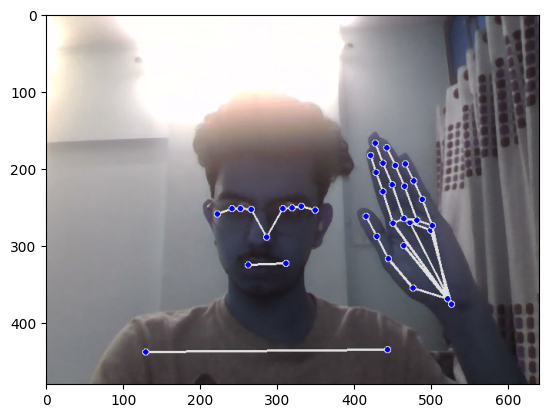

In [8]:
plt.imshow(last_frame['frame'])
last_frame['detected_at']

Sampling

In [11]:
## Note: the Sample video data has been flushed out to conceal personal data

In [9]:
signs = ['hello','how','you','people']
sequence_length = 30
video_length = 30

In [10]:
def create_video_writer(cap, destination):
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(destination, fourcc, fps, (width, height))
    return out

In [ ]:
##create your own data that will be saved in sample folder

def construct_video(sign):
    cap = cv2.VideoCapture(1)#1 for external source
    try: 
        for sequence in range(sequence_length):
            os.makedirs(os.path.join(SAMPLE_PATH,sign),exist_ok=True)
            output_video_path = os.path.join(SAMPLE_PATH,sign,str(sequence)+'.mp4')
            out = create_video_writer(cap,output_video_path)

            for frame_number in range(video_length):
                ret, frame = cap.read() #read 
                frame = cv2.flip(frame,1)
                if not ret:
                    break

                if frame_number == 0:
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(frame, 'Starting Collection', (0, 20), font, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.putText(frame, f'Sequence {sequence} for sign\'{sign}\'', (0, 40), font, 0.55, (0, 200, 0), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', frame)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(frame, f'Sequence {sequence} for sign\'{sign}\'', (0, 40), font, 0.55, (0, 200, 0), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', frame)
                out.write(frame)   
                
                if cv2.waitKey(10) & 0xFF == ord('q'):#quit
                    raise Exception('Keyboard interrupt')       
            print(f'saved {output_video_path}')
    finally:
        cv2.destroyAllWindows()
        cap.release()
        out.release()

Data Augmentation

In [ ]:
def random_flip(frame,to_flip):
    if to_flip:
        return cv2.flip(frame, 1)  
    return frame

In [ ]:
def random_zoom(frame,zoom_factor):
    h, w = frame.shape[:2]
    zoom_matrix = cv2.getRotationMatrix2D((w / 2, h / 2), 1, zoom_factor)
    zoomed_frame = cv2.warpAffine(frame, zoom_matrix, (w, h))
    return zoomed_frame

In [ ]:
def random_brightness_contrast(frame,alpha,beta):
    augmented_frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)
    return augmented_frame

In [ ]:
def random_rotation(frame,angle):
    h, w = frame.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_frame = cv2.warpAffine(frame, rotation_matrix, (w, h))
    return rotated_frame

In [ ]:
def perform_augmentation(frame,to_flip,rotation_angle,brightness_alpha,contrast_beta,zoom_factor):
    frame = random_flip(frame,to_flip)
    frame = random_zoom(frame,zoom_factor)
    frame = random_brightness_contrast(frame,brightness_alpha,contrast_beta)
    frame = random_rotation(frame,rotation_angle)
    return frame

In [ ]:
def get_augmentation_parameters():
    to_flip = True if np.random.rand() > 0.5 else False
    rotation_angle = np.random.uniform(-15, 15)
    brightness_alpha = np.random.uniform(0.8, 1.2)
    contrast_beta = np.random.uniform(0.8, 1.2)
    zoom_factor = np.random.uniform(0.8, 1.2)
    return to_flip,rotation_angle,brightness_alpha,contrast_beta,zoom_factor

In [ ]:
def apply_augmentation():
    for sign in signs:
        videos = os.listdir(os.path.join(SAMPLE_PATH,sign))
        counter = len(videos)
        print(f'in {sign} :')
        for video in videos:
            input_video_path = os.path.join(SAMPLE_PATH,sign,video)
            cap = cv2.VideoCapture(input_video_path)
            output_video_path = os.path.join(SAMPLE_PATH,sign,str(counter+1)+'.mp4')
            out = create_video_writer(cap,output_video_path)
            try:
                if cap.isOpened():
                    to_flip,rotation_angle,brightness_alpha,contrast_beta,zoom_factor = get_augmentation_parameters() #runs once per video
                    while cap.isOpened():
                        ret, frame = cap.read() #read 
                        if not ret:
                            break
                        frame = perform_augmentation(frame,to_flip, rotation_angle,brightness_alpha,contrast_beta,zoom_factor)
                        out.write(frame)   
                    print(f'saved {output_video_path}')
                    counter += 1
                else:
                    print(f'cannot open {input_video_path}')
            except Exception as e:
                print(e)
                print(f'failed to augment {input_video_path}')
                sys.exit()
            finally:
                cap.release()
                out.release()
    print('Augmentation Complete')
            

In [ ]:
apply_augmentation()

Creating MP_Data

In [32]:
def extract_data(results):
    left_hand_data = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand_data = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([left_hand_data,right_hand_data])

In [ ]:
exit = False

last_frame = None

for sign in signs:

    sign_path = os.path.join(SAMPLE_PATH,sign)
    #list of videos in that sign
    videos = os.listdir(sign_path) 
    counter_1 = 0
    for video in videos:
        if exit:
            raise Exception("User Exit")
        VIDEO_PATH = os.path.join(sign_path,video)

        #checking if viedo exists in VIDEO_DATA
        if os.path.exists(VIDEO_PATH):
            #make dir of same name in MP_DATA
            dir_path = os.path.join(DATA_PATH,sign,str(counter_1))
            os.makedirs(dir_path,exist_ok=True)
            cap = cv2.VideoCapture(VIDEO_PATH)

            with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
                try:
                    #checking if the video can be opened
                    if cap.isOpened():
                        for frame_no in range(sequence_length):
                            npy_path = os.path.join(dir_path,str(frame_no))
                            ret, frame = cap.read() 
                            #if the sequence length exceeds the video length
                            if not ret:
                                frame = last_frame
                            image, results, hand_detected = mediapipe_detection(frame,holistic) #apply model 
                            draw_landmarks(image, results) #draw results
                            cv2.imshow('Preview',image)
                            #saving the data :
                            keypoints_data = extract_data(results)
                            np.save(npy_path,keypoints_data)
                            print(f'saved {npy_path}')
                            last_frame = frame 
                            if cv2.waitKey(10) & 0xFF == ord('q'):#quit
                                print(f'!Quitting at {VIDEO_PATH}')
                                exit = True
                                break
                        counter_1 += 1
                    else:
                        print(f'!Cannot open video {VIDEO_PATH}')
                finally:
                    cap.release()
                    cv2.destroyAllWindows()


        else:
            print(f'!Path {VIDEO_PATH} does not exist')


# The Model

Preprocessing and Labeling Data

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [13]:
label_map = {label:num for num, label in enumerate(signs)}
label_map

{'hello': 0, 'how': 1, 'you': 2, 'people': 3}

In [14]:
sequences, labels = [],[] #X and Y dataset
for sign in signs:
    sign_path = os.path.join(DATA_PATH,sign)
    for sequence in range(len(os.listdir(sign_path))):
        sequence_path = os.path.join(sign_path,str(sequence))
        print(f'done sequence {sequence_path}')
        window = []
        for frame in range(len(os.listdir(sequence_path))):
            frame_path = os.path.join(sequence_path,f'{frame}.npy')  
            res = np.load(frame_path)
            window.append(res)
        sequences.append(window)
        labels.append(label_map[sign])

done sequence MP_DATA\hello\0
done sequence MP_DATA\hello\1
done sequence MP_DATA\hello\2
done sequence MP_DATA\hello\3
done sequence MP_DATA\hello\4
done sequence MP_DATA\hello\5
done sequence MP_DATA\hello\6
done sequence MP_DATA\hello\7
done sequence MP_DATA\hello\8
done sequence MP_DATA\hello\9
done sequence MP_DATA\hello\10
done sequence MP_DATA\hello\11
done sequence MP_DATA\hello\12
done sequence MP_DATA\hello\13
done sequence MP_DATA\hello\14
done sequence MP_DATA\hello\15
done sequence MP_DATA\hello\16
done sequence MP_DATA\hello\17
done sequence MP_DATA\hello\18
done sequence MP_DATA\hello\19
done sequence MP_DATA\hello\20
done sequence MP_DATA\hello\21
done sequence MP_DATA\hello\22
done sequence MP_DATA\hello\23
done sequence MP_DATA\hello\24
done sequence MP_DATA\hello\25
done sequence MP_DATA\hello\26
done sequence MP_DATA\hello\27
done sequence MP_DATA\hello\28
done sequence MP_DATA\hello\29
done sequence MP_DATA\how\0
done sequence MP_DATA\how\1
done sequence MP_DATA\ho

In [15]:
np.array(sequences).shape
# 120 videos [30 for 4 signs], 30 frames each, 258 data points [21 left hand, 21 right hand] for (x, y, z) cords.

(120, 30, 126)

In [16]:
np.array(labels).shape

(120,)

In [17]:
X = np.array(sequences)
Y = to_categorical(labels).astype(int)

In [18]:
Y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1,

Train Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.05)

In [20]:
X_train.shape

(114, 30, 126)

In [21]:
X_test.shape

(6, 30, 126)

Model Training 

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import load_model

ImportError: cannot import name 'load_model' from 'tensorflow.keras' (C:\Users\jives\anaconda3\Lib\site-packages\keras\api\_v2\keras\__init__.py)

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [24]:
if os.path.exists('model_final.keras'):
    print('model loaded')
    model = tf.keras.models.load_model('model_final.keras') 
else:
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(30, 258)),
        Dropout(0.2),  # Increase dropout rate
        LSTM(128, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(64, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(np.array(signs).shape[0], activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001,clipvalue=1.0),loss ='categorical_crossentropy',metrics ='categorical_accuracy')

model loaded


In [ ]:
model.fit(X_train,y_train,epochs = 1000, callbacks = [tb_callback])

In [25]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 30, 64)            48896     
                                                                 
 dropout_35 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_22 (LSTM)              (None, 30, 128)           98816     
                                                                 
 dropout_36 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_23 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 64)               

# Evaluation

In [26]:
from sklearn.metrics import accuracy_score,multilabel_confusion_matrix

In [27]:
yhat = np.argmax(model.predict(X_test),axis=1).tolist()
yhat

1/1 [==============================] - 2s 2s/step


[0, 0, 1, 0, 0, 3]

In [28]:
ytrue = np.argmax(y_test,axis=1).tolist()
ytrue

[0, 0, 1, 0, 0, 3]

In [29]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[2, 0],
        [0, 4]],

       [[5, 0],
        [0, 1]],

       [[5, 0],
        [0, 1]]], dtype=int64)

In [30]:
accuracy_score(ytrue,yhat)

1.0

# Saving the model

In [ ]:
model.save('model_final.keras')

# Real time serving

In [33]:
cap = cv2.VideoCapture(0)
sequence = []
sentence = []
threshold = 0.6

#Testing vedio capture
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    try:
        while cap.isOpened():
            ret, frame = cap.read() #read
            if not ret:
                break
            frame = cv2.flip(frame, 1)
            image, results, hand_detected = mediapipe_detection(frame,holistic) #apply model
            draw_landmarks(image, results) #draw results
            
            keypoints_data = extract_data(results)
            sequence.append(keypoints_data)
            sequence = sequence[-30:]
            if len(sequence) == 30:
                res = model.predict(np.expand_dims(sequence,axis=0))[0]
                word = signs[np.argmax(res)]
                curr_threshold = np.max(res)
                if curr_threshold > threshold:
                    if len(sentence) > 0:
                        if word != sentence[-1]:
                            sentence.append(word)
                    else:
                        sentence.append(word)
            if len(sentence) > 5:
                sentence = sentence[-5:]

            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image, f'{sentence}', (0, 20), font, 1, (0, 0, 255), 1, cv2.LINE_AA)
            cv2.imshow('OpenCV Feed', image)#show
            if cv2.waitKey(10) & 0xFF == ord('q'):#quit
                raise Exception('Keyboard interrupt')
    finally:
        cap.release()
        cv2.destroyAllWindows()


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


Exception: Keyboard interrupt